In [1]:
from pipeline.Pipeline import Load
import pandas as pd


load_df = Load()

final_df = load_df.load_restaraunts() 


from datetime import datetime


import pandas as pd
current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute
csv_name = f'dataframe{dia}-{month}-{year}AT{hour}:{min}.csv'

#final_df = pd.read_csv('dataframe2-12-2024AT21:41.csv')
df =final_df
df.to_csv(csv_name,index=True)


df.columns




Index(['restaurant_id', 'fantasy_name', 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery', 'has_stone',
       'sessions_count', 'mrr', 'created_at', 'deleted_at', 'survival_days',
       'is_deleted', 'total_users', 'fat_anti_penult_sem', 'fat_penult_sem',
       'fat_ult_sem', 'variance_x', 'std_dev_x', 'fat_ant_penul_sem',
       'fat_penul_sem', 'comandas_anti_penul_sem', 'comandas_penul_sem',
       'comandas_ult_sem', 'variance_y', 'std_dev_y', 'average_table_session'],
      dtype='object')

In [12]:


# Filtrar os dados onde is_deleted == 0
restaurantes_nao_deletados = final_df[final_df['is_deleted'] == 0]

# Selecionar 200 amostras aleatórias
amostras_selecionadas = restaurantes_nao_deletados.sample(n=10, random_state=54)

# Salvar essas amostras em um CSV, se necessário
amostras_selecionadas.to_csv('amostras_teste.csv', index=False)

print(f"Número de amostras selecionadas: {len(amostras_selecionadas)}")

final_df = final_df.drop(amostras_selecionadas.index)

Número de amostras selecionadas: 10


In [13]:
import numpy as np

q1 = np.percentile(final_df['survival_days'].astype(float), 25)
q3 = np.percentile(final_df['survival_days'].astype(float), 75)
iqr = q3 - q1

mediana = np.median(final_df['survival_days'].astype(float))
media = np.mean(final_df['survival_days'].astype(float))
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = final_df[(final_df['survival_days'].astype(float) < limite_inferior) | (final_df['survival_days'].astype(float) > limite_superior)]
print(f"Mediana: {mediana}")
print(f"Média: {media}")
print(outliers)
print(f"Número de outliers: {len(outliers)}")

Mediana: 162.0433194849537
Média: 250.63768757090477
     restaurant_id              fantasy_name  has_club  has_ifood  \
5                8              Rei do Peixe         0          0   
8               11                 Pop Motel         0          0   
10              13                 Top Sushi         1          1   
16              19                Taberna 91         0          0   
17              20            Caffè Lorenzon         1          1   
..             ...                       ...       ...        ...   
296            314           Mark - Zona Sul         1          1   
298            316       Casa Stein - Matriz         0          0   
299            317  House Burguer & Piemonte         0          0   
301            319           Lagunn Gourmet          0          0   
309            327               Shôga Sushi         0          1   

     is_multistore_related  has_fiscal  only_delivery  has_stone  \
5                        0           0            

In [14]:

from datetime import datetime


import pandas as pd
current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute


df = pd.DataFrame(final_df)


df.columns


Index(['restaurant_id', 'fantasy_name', 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery', 'has_stone',
       'sessions_count', 'mrr', 'created_at', 'deleted_at', 'survival_days',
       'is_deleted', 'total_users', 'fat_anti_penult_sem', 'fat_penult_sem',
       'fat_ult_sem', 'variance_x', 'std_dev_x', 'fat_ant_penul_sem',
       'fat_penul_sem', 'comandas_anti_penul_sem', 'comandas_penul_sem',
       'comandas_ult_sem', 'variance_y', 'std_dev_y', 'average_table_session'],
      dtype='object')

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [16]:


features_to_impute = [
 'has_club','has_ifood',
       'is_multistore_related', 'has_fiscal',
       'mrr', 'average_table_session','sessions_count',
       'total_users', 'fat_anti_penult_sem', 'fat_penult_sem', 'fat_ult_sem', 'variance_x',
       'std_dev_x', 'comandas_anti_penul_sem', 'comandas_penul_sem', 'comandas_ult_sem',
     
]

X = df[features_to_impute]
X_to_impute = df[features_to_impute]
y_time = df['survival_days'].astype(float)  # Tempo até o evento
y_event = df['is_deleted'].astype(bool)    # Churn ocorreu ou não


In [17]:
imputer = SimpleImputer(strategy='mean')
X_imputed= imputer.fit_transform(X_to_impute)
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_imputed)

In [18]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

In [19]:



y = Surv.from_arrays(event=y_event, time=y_time)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  
    y,        
    test_size=0.5,  
    random_state=42,  
    stratify=y_event 
)







rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=20,max_depth=10, random_state=42)


rsf.fit(X_train, y_train)


c_index_train = rsf.score(X_train, y_train)  # Avaliar no conjunto de treino
c_index_test = rsf.score(X_test, y_test)    # Avaliar no conjunto de teste

print(f"C-Index no conjunto de treino: {c_index_train}")
print(f"C-Index no conjunto de teste: {c_index_test}")



C-Index no conjunto de treino: 0.8724812116167588
C-Index no conjunto de teste: 0.838010134582902


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean
sorted_indices = np.argsort(importances)[::-1]

# Mostrar as características mais importantes
for i in sorted_indices:
    print(f"Feature: {features_to_impute[i]}, Importance: {importances[i]}")


In [20]:
from sksurv.metrics import brier_score

import numpy as np

surv_funcs = rsf.predict_survival_function(X_test)


y_test_structured = np.array(

    [(event, time) for event, time in y_test],
    dtype=[("event", bool), ("time", float)]

)



y_train_structured = np.array(

    [(event, time) for event, time in y_train],
    dtype=[("event", bool), ("time", float)]
)

min_test_time = y_test_structured["time"].min()
max_test_time = y_test_structured["time"].max()

time_horizons = np.arange(30, 1500, 90)
surv_probs = np.array([[fn(t) for t in time_horizons] for fn in surv_funcs ])




# Calcular o Brier Score
times, brier_scores = brier_score(y_train_structured, y_test_structured, surv_probs, time_horizons)


print(np.mean(brier_scores))

0.07575067553895355


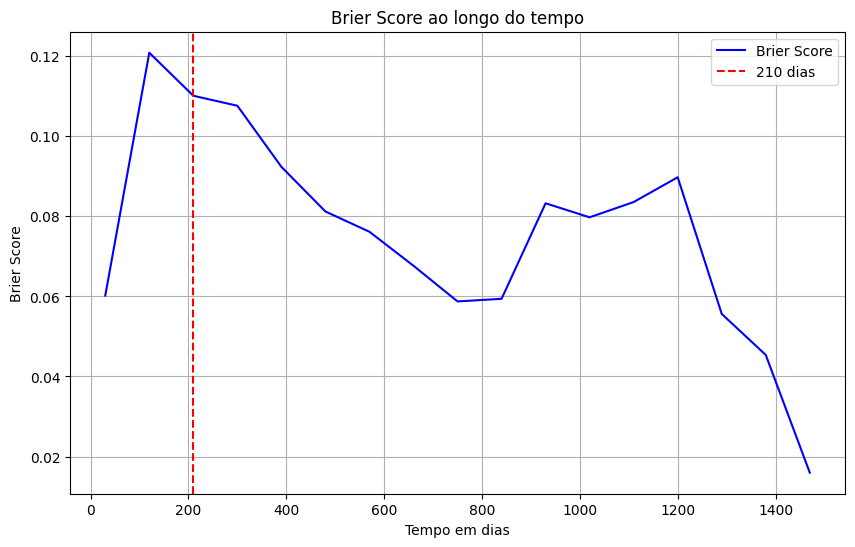

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, label="Brier Score", color="blue")
plt.axvline(x=210, color="red", linestyle="--", label="210 dias")
plt.xlabel("Tempo em dias")
plt.ylabel("Brier Score")
plt.title("Brier Score ao longo do tempo")
plt.legend()
plt.grid()
plt.show()


Estatistica Ifood: 79.67351913890586
P-value Ifood: 4.4168086039501555e-19
Estatistica Clube: 54.94672709707398
P-value Clube: 1.2384143726617146e-13
Há uma diferença estatisticamente significativa entre os grupos(CLUBE).
Há uma diferença estatisticamente significativa entre os grupos(IFOOD).


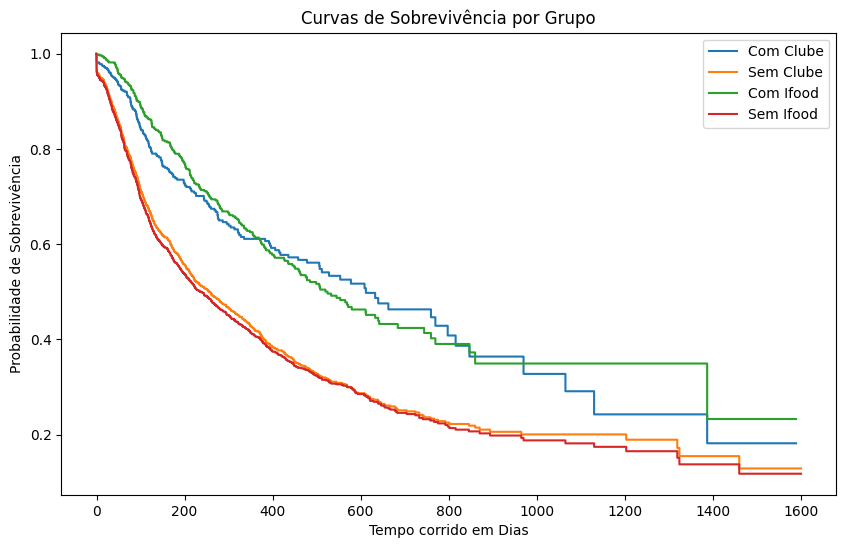

In [16]:
from lifelines.statistics import KaplanMeierFitter,logrank_test

clientes_clube = df[df['has_club']==1]
clientes_sem_clube = df[df['has_club']==0]
clientes_ifood = df[df['has_ifood'] == 1]
clientes_sem_ifood = df[df['has_ifood']==0]

results_clube = logrank_test(clientes_clube['survival_days'].astype(float),
                       clientes_sem_clube['survival_days'].astype(float),
                       event_observed_A=clientes_clube['is_deleted'],
                       event_observed_B=clientes_sem_clube['is_deleted']
                       
                       )

results_ifood = logrank_test(clientes_ifood['survival_days'].astype(float),
                       clientes_sem_ifood['survival_days'].astype(float),
                       event_observed_A=clientes_ifood['is_deleted'],
                       event_observed_B=clientes_sem_ifood['is_deleted'])



print(f'Estatistica Ifood: {results_ifood.test_statistic}')
print(f'P-value Ifood: {results_ifood.p_value}')

print(f'Estatistica Clube: {results_clube.test_statistic}')
print(f'P-value Clube: {results_clube.p_value}')



if results_clube.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(CLUBE).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(CLUBE).")


if results_ifood.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(IFOOD).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(IFOOD).")


kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))


kmf.fit(clientes_clube['survival_days'], event_observed=clientes_clube['is_deleted'], label="Com Clube")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_clube['survival_days'], event_observed=clientes_sem_clube['is_deleted'], label="Sem Clube")
kmf.plot_survival_function(ci_show = False)


kmf.fit(clientes_ifood['survival_days'], event_observed=clientes_ifood['is_deleted'], label="Com Ifood")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_ifood['survival_days'], event_observed=clientes_sem_ifood['is_deleted'], label="Sem Ifood")
kmf.plot_survival_function(ci_show = False)

plt.title("Curvas de Sobrevivência por Grupo")
plt.xlabel("Tempo corrido em Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

  